#### Import all the pkgs

In [1]:
import torch
import numpy as np
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
from model_research import AutoEncoder, train
from naturalityscore import naturality_score
import matplotlib.pyplot as plt
%matplotlib inline

capsNN_weights_path = '/home/jevjev/Dropbox/Projects/DeepBayesApplication/autoencoder_task/CapsuleNet/result/epoch17.pkl'
batch_size = 50
gpu_id = 0
inp_size = 784
hid_size = 20

#### Load data

In [2]:
get_loader = lambda train: torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=train, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
train_loader, test_loader = get_loader(True), get_loader(False)

# Question 1

In research question number 1, we are asked to study which combination of reconstruction loss, regularisation strenth, number of layers, (etc) lead to more natural images. One way to approach this task, is to iterate over different combinations, observe losses at convergence and investigate the images. Essentially, we have a hyper-parameter optimisation task without a defined objective function. There is a number of proposed methods in the literature, to approach such task, where we can provide preference to one or another result produced by an algorithm given certain combination of hyper-parameters. See [Gonzalez et al. 2017](https://arxiv.org/abs/1704.03651) for example, or a really cool application to fusion experiments [Baltz et al. 2017](https://www.nature.com/articles/s41598-017-06645-7). 

Although, the methods above are really cool, I would still have to spend time examining images, without an *objective* way to trully evaluate the visual quality. Hence, I thought to experiment by constructing a function that would score how natural the images are. I modify the **Inception score** proposed for measuring the quality of images generated using GANs by [Salimans et al. 2016](https://papers.nips.cc/paper/6125-improved-techniques-for-training-gans). The **Inception score** is computed by using Inception CNN to generate conditional label distribution $p(y| \mathbf{x})$, if images are of good quality the corresponding distribution would be of low entropy. By computing the marginal $\int p(y|\mathbf{x})d\mathbf{x}$ we evaluate the diversity within generated images. Given that in our case we will use the same MNIST validation data to compute the score, marginal I suspect would be more or less the same, and most of the information will come from conditional label distribution $p(y| \mathbf{x})$. I modify the Inception score as described by [Barratt and Sharma 2018](https://arxiv.org/abs/1801.01973), and by pre-training a CapsuleNet [(Sabour, Frosst, and Hinton 2017)](https://arxiv.org/abs/1710.09829)  on MNIST (val. acc. 99.66) to use instead of the Inception model. The code for the function can be found on my github page [here](https://github.com/jgamper/DeepBayesApplication/blob/master/autoencoder_task/naturalityscore.py).

I proceed to use this modified Inception score as an objective for hyper-parameter optimisation task. By maximising this objective function, I hope to find a combination of hyper parameters producing most natural reconstructions. 

In our case hyper-parameters are: 

* Number of layers (up to 6)
* Reconstruction loss type L1 or L2 norm
* Regularisation type L1 or L2
* Include or exclude Batch Normalisation
* Regularisation weight $\lambda$

<br><br>

Let us first see, what would be the highest possible score, by computing the modified inception score for original MNIST validation images.

In [3]:
# By giving model=None, the score will be computed only on validation images
mean, std = naturality_score(test_loader, batch_size=batch_size, 
                             gpu_id=gpu_id, weights_path=capsNN_weights_path, model=None)

In [4]:
print('Score for the validation data: {:.3f} and its standard deviation: {:.3f}'.format(mean, std))

Score for the validation data: 1.216 and its standard deviation: 0.206


Now we will initalise an autoencoder with 3 layers, batch-norm, and see what sort of score it will produce untrained.

In [5]:
autoencoder = AutoEncoder(inp_size=inp_size, hid_size=hid_size, num_layers=3, include_bn=True)
autoencoder = autoencoder.cuda(gpu_id)

In [6]:
mean, std = naturality_score(test_loader, batch_size=batch_size, 
                             gpu_id=gpu_id, weights_path=capsNN_weights_path, model=autoencoder)

In [7]:
print('Score for the validation data: {:.3f} and its standard deviation: {:.3f}'.format(mean, std))

Score for the validation data: 0.083 and its standard deviation: 0.054


<br><br>

We will let the number of layers from 2 to 6; L1 or L2 regularisation; L1 or L2 reconsturction loss; with or without batch norm; and $\lambda \in [0, 0.009]$. We will vary the hyper-parameters and attempt to minimize the negative of our objective function defined above.

In [3]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# Define the list of hyper-param to optimise
space = [Integer(2, 6),  # Number of layers
        Integer(0, 1),   # Loss type 1 L1, 0 L2
        Integer(0, 1),   # Regularisation type 1 L1, 0 L2
        Integer(0, 1),   # If 1 batch norm is on
        Real(0, 0.009)]  # Regularisation strength

In [6]:
def objective(params):
    n_layers = params[0]
    loss_type = params[1]
    reg_type = params[2]
    batch_norm = params[3]
    lam = params[4]
    
    autoencoder = AutoEncoder(inp_size=784, hid_size=20, num_layers=n_layers,
                             l1_loss=loss_type, l1_weights=reg_type, lam=lam, include_bn=batch_norm)
    autoencoder = autoencoder.cuda(gpu_id)
    optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
    autoencoder = train(autoencoder, optimizer, train_loader, gpu_id)
    
    score, _ = naturality_score(test_loader, batch_size=batch_size, 
                             gpu_id=gpu_id, weights_path=capsNN_weights_path, model=autoencoder)
    
    return -score

In [7]:
from skopt import forest_minimize
res_min = forest_minimize(objective, space, n_calls=50, random_state=0)

In [9]:
print("Best score {:.3f}".format(-res_min.fun))

Best score 1.170


In [10]:
res_min.x

[5, 0, 0, 1, 2.6899945090939075e-06]

Looks like the best score we were able to achieve was 1.17 (validation data by itself has a score of 1.216), with 5 layers in encoder and decoder, l2 norm and l2 regularisation, with batch normalisation included, and extremely low regularisation. Now lets train a brain new model with these parameters and see what sort of result it would produce in terms of visual quality.

In [3]:
num_layers, l1_loss, l1_weights, include_bn, lam = 5, 0, 0, 1, 2.7e-06
autoencoder = AutoEncoder(inp_size=784, hid_size=20, num_layers=num_layers,
                         l1_loss=l1_loss, l1_weights=l1_weights, lam=lam, include_bn=include_bn)
autoencoder = autoencoder.cuda(gpu_id)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
autoencoder = train(autoencoder, optimizer, train_loader, gpu_id)

In [12]:
sample, _ = next(iter(test_loader))
sample = sample.view(-1, 784)[:8,:]
sample = Variable(sample.cuda(gpu_id), requires_grad=False)
sample_rec = autoencoder(sample).data.cpu().view(-1, 1, 28, 28).numpy()
sample = sample.data.cpu().view(-1, 1, 28, 28).numpy()

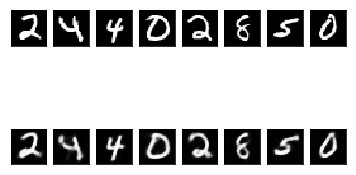

In [13]:
for i in range(sample.shape[0]):
    ax = plt.subplot(2, sample.shape[0], i+1);
    plt.imshow(sample[i,:,:,:].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, sample.shape[0], i+1+sample.shape[0]);
    plt.imshow(sample_rec[i,:,:,:].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The reconstructed images are blurrier than what I would hope, but luckily hyper-parameter search produced something that works. That was an interesting experiment to try. Nevertheless, there are multiple drawbacks with the approach used above. 

First, **Inception score** and therefore our modification has drawbacks, most likely it would be possible to generate very blurry images with some sort of features that would produce high score, as shown in [Barratt and Sharma 2018](https://arxiv.org/abs/1801.01973).

Second, per each hyper-parameter evaluation, I've looked at the score only for one converged model, inherently there is stochasticity in training, initialisation, etc. Therefore, it would have been much better to train at least several models with the same combination of hyper-parameters, and then evaluate the score by taking the mean. 

I have left out the regularisation layers such as drop-out out of optimisation, and will look at them as a separate question.